In [42]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import re


%matplotlib inline

In [5]:
# read in the data
with open('../../datasets/recipes/train.json') as f:
    train_data = json.load(f)
train_data[0:2]

[{'cuisine': 'greek',
  'id': 10259,
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles']},
 {'cuisine': 'southern_us',
  'id': 25693,
  'ingredients': ['plain flour',
   'ground pepper',
   'salt',
   'tomatoes',
   'ground black pepper',
   'thyme',
   'eggs',
   'green tomatoes',
   'yellow corn meal',
   'milk',
   'vegetable oil']}]

In [6]:
with open('../../datasets/recipes/test.json') as f:
    test_data = json.load(f)
test_data[0:2]

[{'id': 18009,
  'ingredients': ['baking powder',
   'eggs',
   'all-purpose flour',
   'raisins',
   'milk',
   'white sugar']},
 {'id': 28583,
  'ingredients': ['sugar',
   'egg yolks',
   'corn starch',
   'cream of tartar',
   'bananas',
   'vanilla wafers',
   'milk',
   'vanilla extract',
   'toasted pecans',
   'egg whites',
   'light rum']}]

Okay so taking a quick look at our data, we have the following format:
* Recipe Entry
    * Train only: Cuisine (prediction value)
    * ID
    * Ingredients
        * Ingredient 1
        * ...
        * Ingredient n
        
We're going to need to put these into a way that we can consume for machine learning. A few things to note:
* The ingredients seem to be kind of specific instead of generic. We may need to do some feature engineering here to make broader classes of ingredients (rum vs light rum, almonds vs toasted almond, etc...).
* There are different number of ingredients in each recipe. We will likely need to take a sparse-matrix feature matrix in order to play around with this.

In [25]:
# ids will not be important for the training, we don't have to worry about extracting these
train_labels = np.array([train_data[x]['cuisine'] for x in range(len(train_data))])
unique_ar = np.unique(train_labels, return_counts=True)
unique_ar

(array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
        'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
        'japanese', 'korean', 'mexican', 'moroccan', 'russian',
        'southern_us', 'spanish', 'thai', 'vietnamese'], dtype='<U12'),
 array([ 467,  804, 1546, 2673,  755, 2646, 1175, 3003,  667, 7838,  526,
        1423,  830, 6438,  821,  489, 4320,  989, 1539,  825], dtype=int64))

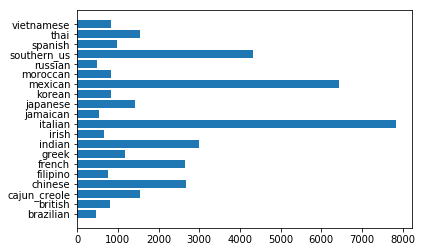

In [29]:
# quick plot of how many of each cuisine are in this dataset
x = np.arange(unique_ar[0].shape[0])
plt.barh(x,unique_ar[1])
plt.yticks(x, unique_ar[0])
plt.show()

OK so we have a lot of italian and mexican and southern recipes. We should make sure our validation set has a good amount of each class so we can see better where we're struggling. Before we get to that though, we ought to turn our features into something useable.

In [36]:
# extract all features from training
train_features = np.array([train_data[x]['ingredients'][i] for x in range(len(train_data)) \
                           for i in range(len(train_data[x]['ingredients']))])
unique_features = np.unique(train_features, return_counts=True)
unique_features[0].shape

(6714,)

OK there's no way I'm looking at all 6714 different ingredients, but we should take a look at a few to see if we can better understand them

In [40]:
np.random.seed(50)
return_items = np.random.randint(0, unique_features[0].shape[0], 50)
unique_features[0][return_items]

array(['squash blossoms', 'sliced kalamata olives', 'cooked vermicelli',
       'umeboshi vinegar', 'cranberry juice cocktail', 'English muffins',
       'turkey', 'vegetable juice', 'Bragg Liquid Aminos', 'horseradish',
       'turkey thigh', 'cubed bread', 'Old El Paso Flour Tortillas',
       'cheese tortellini', 'granita', 'hard cider', 'angel food cake',
       'dates', 'nutmeg', 'jerk paste', 'low-fat cheddar', 'fructose',
       'soda bread', 'white cheddar cheese', 'drippings',
       'refrigerated buttermilk biscuits', 'Zatarains Creole Seasoning',
       'pickled jalapenos', 'half & half',
       'less sodium fat free chicken broth', 'mole sauce',
       'pea eggplants', 'chambord', 'small new potatoes', 'tortillas',
       'Old El Pasoâ„¢ chopped green chiles', 'grana padano',
       'blood orange juice', 'quick-cooking barley', 'mustard oil',
       'clover honey', 'togarashi', 'soy milk', 'tenderloin roast',
       'mian', 'sandwich rolls', 'sour salt', 'bone-in ribeye ste

Turning these into something remotely generalizable looks to be like a difficult problem. Going to do a bit of internet research here...

__Ideas__:

https://www.kaggle.com/ccorbi/word2vec-with-ingredients

https://www.kaggle.com/c/whats-cooking/discussion/23727

https://www.kaggle.com/khyh00/deep-cooking



So the first thing we can do is a little bit of filtering... Let's take out some words from the training that will be re-used a lot in ingredients and not give us much value.

In [61]:
all_recipes = list()
for recipe in train_data:
    clean_recipe = list()
    
    for ingredient in recipe['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced|roasted|diced',
                             '', 
                             ingredient)
        clean_recipe.append(ingredient.strip())
    all_recipes.append(clean_recipe)
np.unique(np.array([all_recipes[i][j] for i in range(len(all_recipes)) for j in range(len(all_recipes[i]))])).shape

(6516,)

Well, doing that process brings down our features by about 200, which is helpful but not really quite what I was hoping for. Maybe we can look at a few more of these ingredients and see if there's more that can be done.

In [62]:
np.random.seed(125)
return_items = np.random.randint(0, unique_features[0].shape[0], 150)
unique_features[0][return_items]

array(['gorgonzola', 'deep dish pie crust', 'sansho',
       'low-fat vegetarian chili with beans', 'scallions',
       'cola-flavored carbonated beverage', 'soy milk',
       'granulated white sugar', 'creamed horseradish',
       'canned chicken breast', 'coffee low-fat frozen yogurt',
       'large snails', 'turkey legs', 'pound cake mix',
       'Jagermeister Liqueur', 'brown rice flour', 'hazelnut liqueur',
       'dried coconut flakes', 'prepared guacamole', 'cashew chop unsalt',
       'pancit canton', 'marjoram leaves', 'irish bacon', 'bitter melon',
       'quick yeast', 'bone in', 'sour mix', 'fresh brussels sprouts',
       'savoiardi', 'pomelo', 'whole wheat french bread',
       'self-rising cornmeal', 'frozen whip topping, thaw',
       'pure acai puree', 'lean ground beef', 'apricots', 'ear of corn',
       'cooked italian meatballs', 'sloe gin',
       'granular no-calorie sucralose sweetener', 'cane sugar',
       'boneless chicken thigh fillets', 'reduced-fat sour cre

Yeah honestly I don't know what to do here. What I do know is that I need to think about getting these somehow into a mtrix-like form in order to put into any machine learning algorithm. Turns out that pandas has some nice ways to do this that I didn't know about.

In [64]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression



In [67]:
# nltk.download()
# if you haven't downloaded, you'll need to

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [68]:
lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))
print(lemmatizer.lemmatize("better", pos="a"))
print(lemmatizer.lemmatize("best", pos="a"))
print(lemmatizer.lemmatize("run"))
print(lemmatizer.lemmatize("run",'v'))

cat
cactus
goose
rock
python
good
best
run
run


I'm going to use code from another notebook that includes using natural language toolkit (nltk) for lemmatization. In short, lemmatization identifies the kind of "root idea" of a word according to what it is and what part of speech it is. So this will reduce some of the variation in our terms.

In [69]:
# code from https://www.kaggle.com/dipayan/whatscooking-python
# first line brings in all the data from json into pandas dataframe. in this case, the structure maps well
# second line brings the ingredients into a new column called 'ingredients_clean_string' which
#     has them all in a single string separated by spaces and a comma
# third line lemmatizes the ingredients as they are brought into a new dataframe column

traindf = pd.read_json("../../datasets/recipes/train.json")
traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']]  
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in traindf['ingredients']]       

testdf = pd.read_json("../../datasets/recipes/test.json") 
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]       


In [70]:
traindf.head()

,cuisine,id,ingredients,ingredients_clean_string,ingredients_string
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce , black olives , grape tomatoe...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour , ground pepper , salt , tomatoes ...",plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs , pepper , salt , mayonaise , cooking oil...",egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]","water , vegetable oil , wheat , salt",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper , shallots , cornflour , cayenne ...",black pepper shallot cornflour cayenne pepper ...


In [73]:
corpus_train = traindf['ingredients_string']
vectorizer_train = TfidfVectorizer(stop_words='english', ngram_range = ( 1 , 1 ),analyzer="word", \
                               max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)

tfidf_tr=vectorizer_train.fit_transform(corpus_train)
tfidf_tr.shape

(39774, 2963)

So, by using this method with lemmatizing and Term-document inverse frequency weighting, we get this down to 2963 features. Documentation for the call is here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

Basically, the important parts:
* We are excluded pre-selected stop words for the english language. These are all presumed to not really bring a lot of meaning and we shouldn't be losing a lot here.
* We are only using 1-grams so this is being done on a word-by-word basis
* We are analyzing word-by-word, extraneous characters are not included
* We are only including words that are found in 57% or more of the documents. May want to think of this as a parameter to tune
* We are choosing not to use smoothing